# Ratings prediction Using NLP

__The objective of this project is to understand the sentiment behind the reviews of different prodcuts scraped from "Flipkart.com" and give them a rating based on that sentiment. Using various ML algorithms, supervised model needs to successfully predict the rating closer to the true value of the scraped rating.__

pip install scikitplot

In [97]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Importing Visualising Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes = True)

# import scikitplot as skplt
from wordcloud import WordCloud, STOPWORDS 

#Importing DataCleaning Libraries
import nltk
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

#Importing Classification Models 
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Importing Classification Model Evaluation Metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, hamming_loss, average_precision_score

#Importing Hyperparameter Tuning model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Importing Serialization libraries
import joblib

In [69]:
df=pd.read_csv("Ratings_mined.csv")

In [70]:
df

,Unnamed: 0,Product,Review,Rating
0,0,Mobile phone,Good mobile,4
1,1,Mobile phone,Good,4
2,2,Mobile phone,Good,4
3,3,Mobile phone,Nice mobile,5
4,4,Mobile phone,Very good,5
...,...,...,...,...
20640,20640,Bluetooth Speaker,Sound clear bass normal bass value of money,5
20641,20641,Bluetooth Speaker,Its very poor quality don't Waste your money,1
20642,20642,Bluetooth Speaker,Very good sound quality I like it and very cle...,4
20643,20643,Bluetooth Speaker,Nice product in this price range .,4


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20645 entries, 0 to 20644
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20645 non-null  int64 
 1   Product     20645 non-null  object
 2   Review      20645 non-null  object
 3   Rating      20645 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 645.3+ KB


No Null values are present

In [72]:
df.describe(include="all")

,Unnamed: 0,Product,Review,Rating
count,20645.00000,20645,20645,20645.000000
unique,NaN,13,12111,NaN
top,NaN,Smartwatch,Good,NaN
freq,NaN,2367,1604,NaN
mean,10322.00000,NaN,NaN,4.189441
std,5959.84249,NaN,NaN,1.249532
min,0.00000,NaN,NaN,1.000000
25%,5161.00000,NaN,NaN,4.000000
50%,10322.00000,NaN,NaN,5.000000
75%,15483.00000,NaN,NaN,5.000000


## Data cleaning:

In [73]:
# removing the index column
df.drop("Unnamed: 0",axis=1,inplace=True)

In [74]:
df.columns

Index(['Product', 'Review', 'Rating'], dtype='object')

In [75]:

#Lower casing all str objects
df['updated_review'] = df['Review'].str.lower()

#Removing all numbers, special characters, web addresses and urls
df['updated_review'] = df['updated_review'].apply(
    lambda item: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", item))  

# remove \n, \d
df['updated_review'] = df['updated_review'].apply(lambda item: re.sub(r"\d+\n", "", item))
                

In [76]:
df

,Product,Review,Rating,updated_review
0,Mobile phone,Good mobile,4,good mobile
1,Mobile phone,Good,4,good
2,Mobile phone,Good,4,good
3,Mobile phone,Nice mobile,5,nice mobile
4,Mobile phone,Very good,5,very good
...,...,...,...,...
20640,Bluetooth Speaker,Sound clear bass normal bass value of money,5,sound clear bass normal bass value of money
20641,Bluetooth Speaker,Its very poor quality don't Waste your money,1,its very poor quality dont waste your money
20642,Bluetooth Speaker,Very good sound quality I like it and very cle...,4,very good sound quality i like it and very cle...
20643,Bluetooth Speaker,Nice product in this price range .,4,nice product in this price range


In [77]:
##eliminating stopwords
stop_corp = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['updated_review'] = df['updated_review'].apply(lambda element: ' '.join([word for word in element.split() if word not in (stop_corp)]))
df.head()

,Product,Review,Rating,updated_review
0,Mobile phone,Good mobile,4,good mobile
1,Mobile phone,Good,4,good
2,Mobile phone,Good,4,good
3,Mobile phone,Nice mobile,5,nice mobile
4,Mobile phone,Very good,5,good


In [78]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [79]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [80]:
#tokenization
df['tokens'] = df['updated_review'].apply(lambda x: word_tokenize(x))

In [56]:
# Lemmatization - converting tokens to root words
def lemmatizer(text):
    lemmatized = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lemmatized

df['tokens_lem'] = df['tokens'].apply(lambda x: lemmatizer(x))
df['tokens_lem'] = df['tokens_lem'].apply(lambda x: " ".join(x)) #to remove commas & make a sentence

In [81]:
lemmatizer=nltk.stem.WordNetLemmatizer()
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
     
#adding POS tags with lemmatization
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged=nltk.pos_tag(nltk.word_tokenize(sentence))
    
    #tuple of (token,wordnet_tag)
    wordnet_tagged=map(lambda x:(x[0],nltk_tag_to_wordnet_tag(x[1])),nltk_tagged)
    
    lemmatized_sentence=[]
    for word,tag in wordnet_tagged:
        if tag is None:
            #if no available tag,append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatized_sentence)

df['tokens_lem']=df['updated_review'].apply(lambda x:lemmatize_sentence(x))

In [82]:
df.sample(8)

,Product,Review,Rating,updated_review,tokens,tokens_lem
11128,Monitor,Good,4,good,[good],good
7597,TV,Tv is very good is speaker is good and discpla...,5,tv good speaker good discplay good,"[tv, good, speaker, good, discplay, good]",tv good speaker good discplay good
19433,Memory card,Best quality,5,best quality,"[best, quality]",best quality
1614,Laptop,Very good product at affordable price,5,good product affordable price,"[good, product, affordable, price]",good product affordable price
12321,Monitor,nice product,5,nice product,"[nice, product]",nice product
15311,Keyboard,The keyword was not working properly. within 6...,1,keyword working properly within 6 months keys ...,"[keyword, working, properly, within, 6, months...",keyword work properly within 6 month key work
8013,TV,Overall it good,5,overall good,"[overall, good]",overall good
18728,Memory card,Super,5,super,[super],super


In [88]:
#  Convert text into vectors using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vec = TfidfVectorizer(max_features = 100000, stop_words='english')
features = tf_vec.fit_transform(df['tokens_lem'])

## EDA

In [90]:
df.columns

Index(['Product', 'Review', 'Rating', 'updated_review', 'tokens',
       'tokens_lem'],
      dtype='object')

<AxesSubplot:>

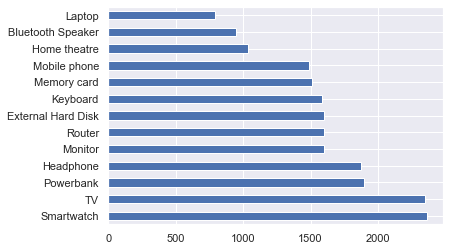

In [86]:
df['Product'].value_counts().plot(kind='barh')

<AxesSubplot:ylabel='Rating'>

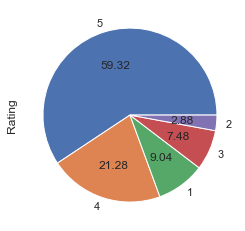

In [92]:
df["Rating"].value_counts().plot(kind="pie",autopct="%.2f")

<AxesSubplot:xlabel='Rating', ylabel='count'>

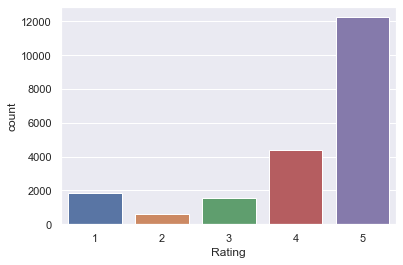

In [93]:
sns.countplot(df["Rating"])

__Data is highly imbalanced, means we'll have to use SMOTE for balancing target classes__

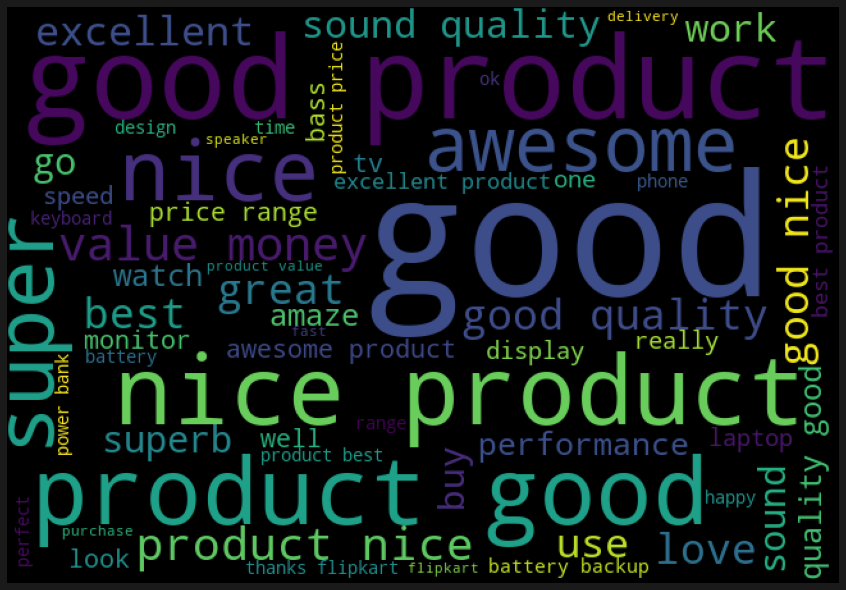

In [100]:
# Viusalising words with rating of 5 stars

rating_star = df['tokens_lem'][df['Rating']==5]
cloud = WordCloud(width=650,height=450,background_color='black',max_words=60).generate(' '.join(rating_star))
plt.figure(figsize=(12,8),facecolor='k')
plt.imshow(cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

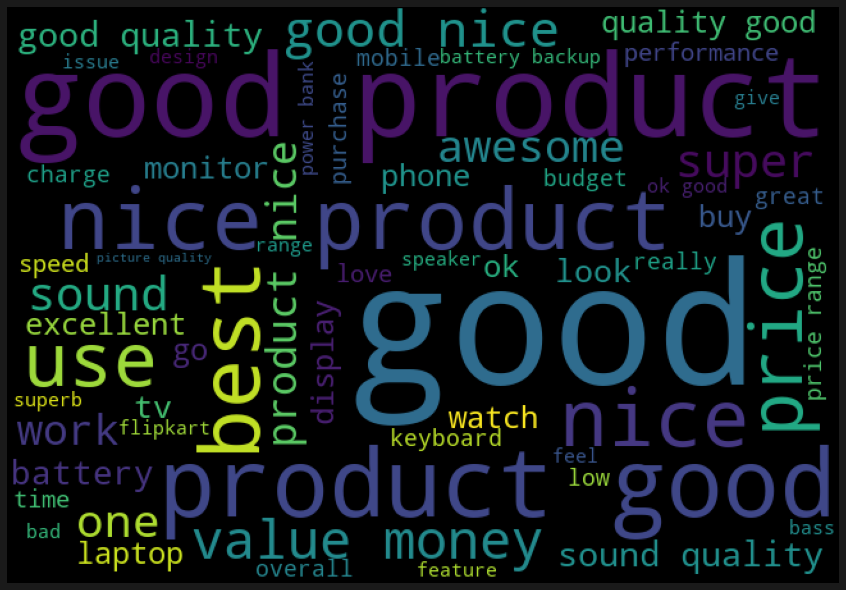

In [101]:
# Viusalising words with rating of 4 stars

rating_star = df['tokens_lem'][df['Rating']==4]
cloud = WordCloud(width=650,height=450,background_color='black',max_words=60).generate(' '.join(rating_star))
plt.figure(figsize=(12,8),facecolor='k')
plt.imshow(cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

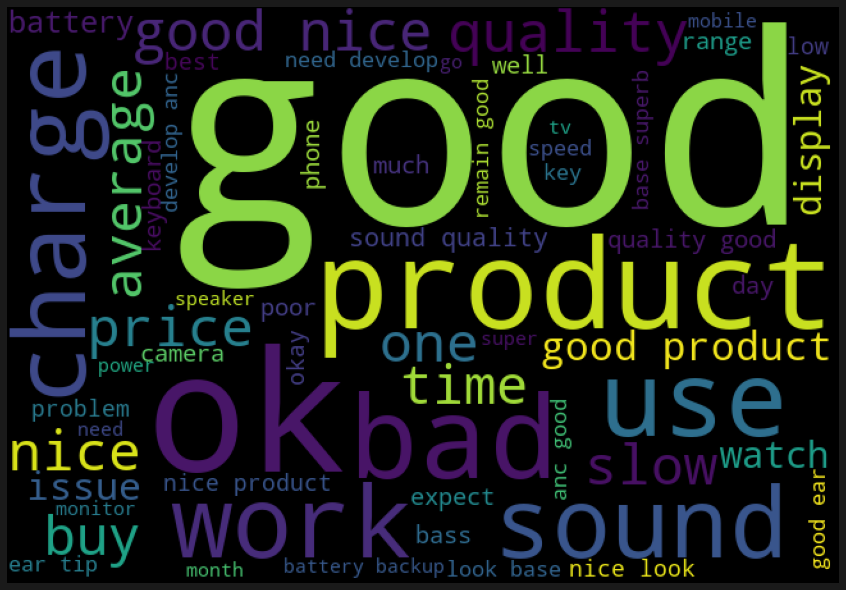

In [102]:
# Viusalising words with rating of 3 stars

rating_star = df['tokens_lem'][df['Rating']==3]
cloud = WordCloud(width=650,height=450,background_color='black',max_words=60).generate(' '.join(rating_star))
plt.figure(figsize=(12,8),facecolor='k')
plt.imshow(cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

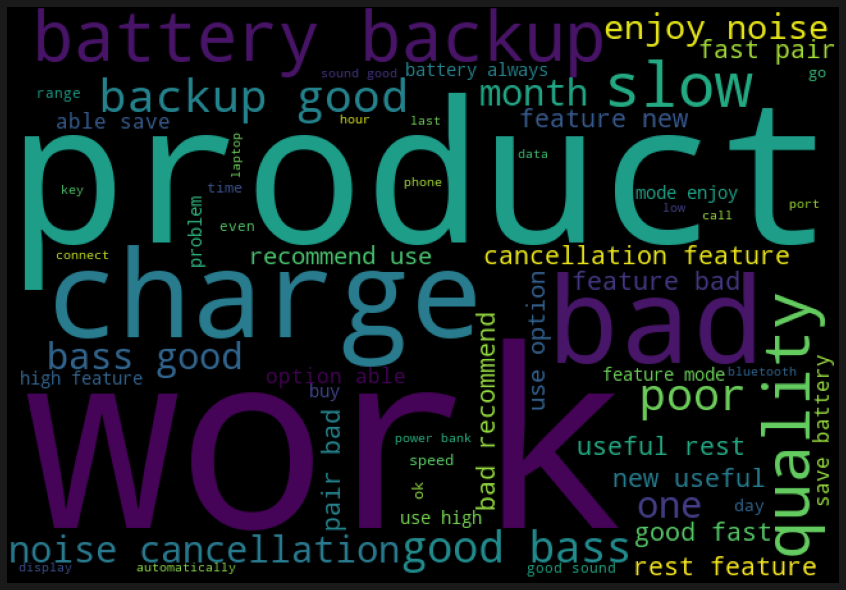

In [104]:
# Viusalising words with rating of 2 stars

rating_star = df['tokens_lem'][df['Rating']==2]
cloud = WordCloud(width=650,height=450,background_color='black',max_words=60).generate(' '.join(rating_star))
plt.figure(figsize=(12,8),facecolor='k')
plt.imshow(cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

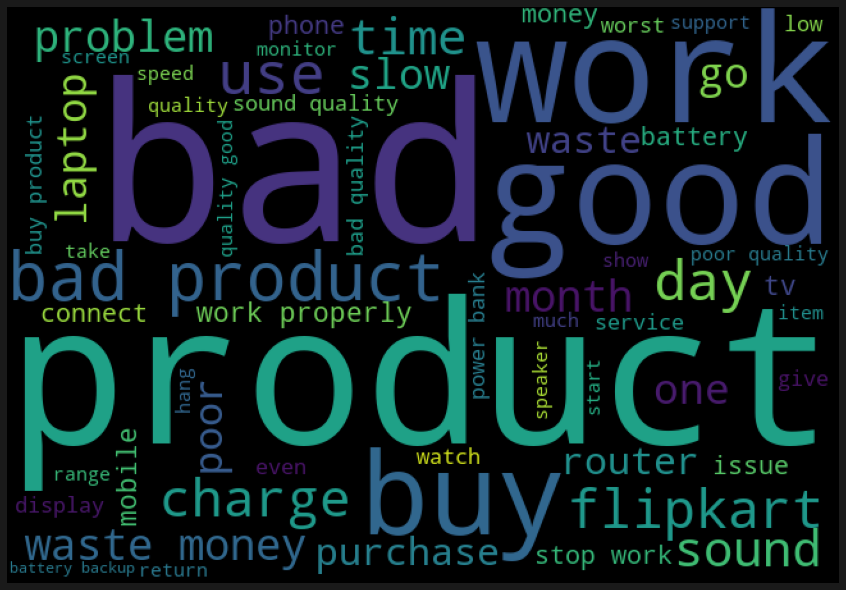

In [105]:
# Viusalising words with rating of 1 star

rating_star = df['tokens_lem'][df['Rating']==1]
cloud = WordCloud(width=650,height=450,background_color='black',max_words=60).generate(' '.join(rating_star))
plt.figure(figsize=(12,8),facecolor='k')
plt.imshow(cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

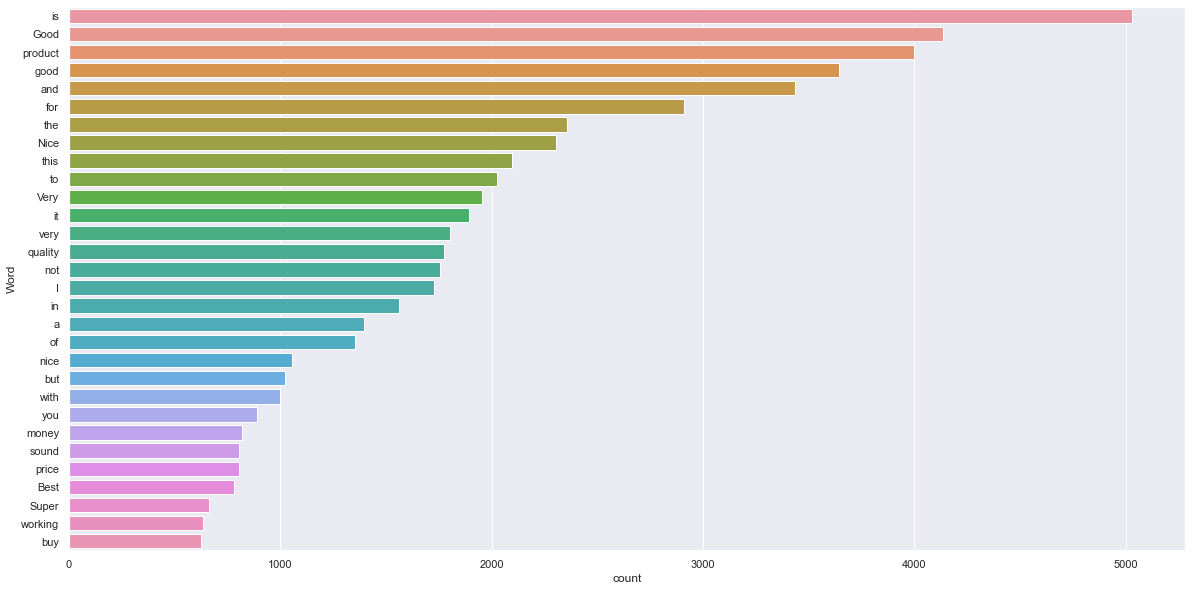

None


In [110]:
#4.Frequency distribution of top 30 words
 
def freq_words(x,terms=30):
    all_words=' '.join([text for text in x])
    all_words=all_words.split()
    
    fdist=FreqDist(all_words)
    words_df=pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})
    
    #selecting top 20 frequent words
    d=words_df.nlargest(columns='count',n=terms)
    plt.figure(figsize=(20,10))
    ax=sns.barplot(data=d,x='count',y='word')
    ax.set(ylabel='Word')
    plt.show()
    

print(freq_words(df['Review']))

<AxesSubplot:xlabel='Review_AWL', ylabel='Density'>

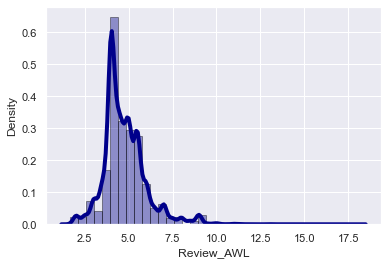

In [112]:
#3.Average word length

def avg_word(sentence):
    words=sentence.split()
    return(sum(len(word) for word in words)/len(words))

#Density plot and histogram of average word length
sns.distplot(df['Review_AWL'],hist=True,kde=True,
              bins=int(180/5),color='darkblue',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth':4})

## Model Building

In [115]:
#Dividing into target and features
X = features
y = df['Rating']

In [116]:
y.value_counts()

5    12246
4     4393
1     1867
3     1544
2      595
Name: Rating, dtype: int64

In [120]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=49)

print(y_train.shape)
print(y_test.shape)

print(x_train.shape)
print(x_test.shape)

(15483,)
(5162,)
(15483, 6834)
(5162, 6834)


In [121]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [122]:
smt = SMOTE(random_state=0)
oversample = SMOTE()
x_train_sm, y_train_sm= oversample.fit_resample(x_train, y_train)
#we'll use Counter as there are multiple unique variables to be counted which will be tediuos if done manually
print("The number of classes before fit{}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_sm)))

The number of classes before fitCounter({5: 9189, 4: 3291, 1: 1395, 3: 1159, 2: 449})
The number of classes after fit Counter({5: 9189, 4: 9189, 1: 9189, 3: 9189, 2: 9189})


## Logistic Regression

In [124]:
# LogisticRegression
Logr = LogisticRegression(C=1, max_iter = 3000)

Logr.fit(x_train_sm, y_train_sm)

y_pred_train = Logr.predict(x_train_sm)
print('Training accuracy is {}'.format(accuracy_score(y_train_sm, y_pred_train)))
y_pred_test = Logr.predict(x_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))

print(classification_report(y_test,y_pred_test))

Training accuracy is 0.678115137664599
Test accuracy is 0.5286710577295621
              precision    recall  f1-score   support

           1       0.58      0.64      0.61       472
           2       0.18      0.35      0.24       146
           3       0.25      0.31      0.28       385
           4       0.31      0.44      0.36      1102
           5       0.77      0.58      0.66      3057

    accuracy                           0.53      5162
   macro avg       0.42      0.46      0.43      5162
weighted avg       0.60      0.53      0.55      5162



In [127]:
cvscore_LR = cross_val_score(Logr,X,y,cv = 10 )
print("Cross val score of Logistic Regression is :", round(cvscore_LR.mean(),4)*100,'%')

Cross val score of Logistic Regression is : 64.81 %


## Random Forest Classifier

In [131]:
RF = RandomForestClassifier()
RF.fit(x_train_sm, y_train_sm)

# Performing Evaluation metrics for our model
predrf=RF.predict(x_test)
print('Accuracy Score :',round(accuracy_score(y_test,predrf),4)*100,'% \n')
print('Classification : \n',classification_report(y_test,predrf))
print("Hamming Loss : ",hamming_loss(y_test,predrf)) 
#hamming loss value ranges from 0 to 1. Lesser value of hamming loss indicates a better classifier.

Accuracy Score : 58.120000000000005 % 

Classification : 
               precision    recall  f1-score   support

           1       0.61      0.70      0.65       472
           2       0.35      0.31      0.33       146
           3       0.32      0.30      0.31       385
           4       0.33      0.43      0.37      1102
           5       0.75      0.67      0.71      3057

    accuracy                           0.58      5162
   macro avg       0.47      0.48      0.47      5162
weighted avg       0.61      0.58      0.59      5162

Hamming Loss :  0.418829910887253


In [132]:
CVscore_RF = cross_val_score(RF,X,y,cv = 10 )
print("Cross validation score :", round(CVscore_RF.mean(),4)*100,'%')

Cross validation score : 65.53999999999999 %


## Decision Tree Classifier

In [134]:
DT = DecisionTreeClassifier()
DT.fit(x_train_sm, y_train_sm)

# Performing Evaluation metrics for our model
preddt=DT.predict(x_test)
print('Accuracy Score :',round(accuracy_score(y_test,preddt),4)*100,'% \n')
print('Classification : \n',classification_report(y_test,preddt))
print("Hamming Loss : ",hamming_loss(y_test,preddt))

Accuracy Score : 55.19 % 

Classification : 
               precision    recall  f1-score   support

           1       0.58      0.62      0.60       472
           2       0.26      0.34      0.29       146
           3       0.29      0.28      0.29       385
           4       0.32      0.44      0.37      1102
           5       0.75      0.63      0.68      3057

    accuracy                           0.55      5162
   macro avg       0.44      0.46      0.45      5162
weighted avg       0.59      0.55      0.57      5162

Hamming Loss :  0.44808213870592795


In [135]:
CVscore_DT = cross_val_score(DT,X,y,cv = 10 )
print("Cross validation score :", round(CVscore_DT.mean(),4)*100,'%')

Cross validation score : 61.809999999999995 %


## LinearSVC

In [136]:
from sklearn.svm import LinearSVC

In [140]:
svc = LinearSVC(max_iter = 3000)
svc.fit(x_train_sm,y_train_sm)

LinearSVC(max_iter=3000)

In [141]:
# Performing Evaluation metrics for our model
predsvc= svc.predict(x_test)
print('Accuracy Score :',round(accuracy_score(y_test,predsvc),4)*100,'% \n')
print('Classification : \n',classification_report(y_test,predsvc))
print("Hamming Loss : ",hamming_loss(y_test,predsvc))


Accuracy Score : 52.83 % 

Classification : 
               precision    recall  f1-score   support

           1       0.54      0.61      0.57       472
           2       0.18      0.36      0.24       146
           3       0.26      0.30      0.28       385
           4       0.31      0.44      0.36      1102
           5       0.77      0.59      0.66      3057

    accuracy                           0.53      5162
   macro avg       0.41      0.46      0.42      5162
weighted avg       0.59      0.53      0.55      5162

Hamming Loss :  0.47171638899651297


In [143]:
CVscore_svc = cross_val_score(svc,X,y,cv = 10 )
print("Cross validation score :", round(CVscore_svc.mean(),4)*100,'%')

Cross validation score : 63.13999999999999 %


## AdaBoost Classifier

In [144]:
AB = AdaBoostClassifier()
AB.fit(x_train_sm,y_train_sm)

AdaBoostClassifier()

In [146]:
# Performing Evaluation metrics for our model
predada= AB.predict(x_test)
print('Accuracy Score  :',round(accuracy_score(y_test,predada),4)*100,'% \n')
print('Classification  : \n',classification_report(y_test,predada))
print("Hamming Loss  : ",hamming_loss(y_test,predada))

Accuracy Score  : 49.26 % 

Classification  : 
               precision    recall  f1-score   support

           1       0.59      0.65      0.62       472
           2       0.18      0.29      0.22       146
           3       0.14      0.32      0.19       385
           4       0.29      0.32      0.30      1102
           5       0.75      0.56      0.64      3057

    accuracy                           0.49      5162
   macro avg       0.39      0.43      0.40      5162
weighted avg       0.58      0.49      0.52      5162

Hamming Loss  :  0.5073614877954281


In [147]:
CVscore_adaboost = cross_val_score(AB,X,y,cv = 10 )
print("Cross validation score of AdaBoost Classifier is :",round(CVscore_adaboost.mean(),4)*100,'%')

Cross validation score of AdaBoost Classifier is : 63.57000000000001 %


__As we can see the difference is minimum when using Decision Tree , but the value of Hamming loss in Random forest  model is much lower compared to Decision Tree so we'll perform Hyperparameter tuning for Decision Tree Classifier.__

## Hyperparameter Tuning

### Random Forest Model

In [152]:
params = {'min_samples_leaf':[4,6,8],
         'n_estimators' : [120,140,160],
         'criterion' : ['gini','entropy'],
         'max_depth':[5,10],
         'min_samples_split':[5,9]}
#Instantiating Randomized SearchCV
randomcv = RandomizedSearchCV(estimator = RF, param_distributions = params)

In [153]:
randomcv.fit(x_train_sm,y_train_sm)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 9],
                                        'n_estimators': [120, 140, 160]})

In [155]:
randomcv.best_params_

{'n_estimators': 160,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 10,
 'criterion': 'gini'}

In [156]:
model_tuned = RandomForestClassifier(n_estimators = 160, min_samples_split = 5, min_samples_leaf = 4,
                               max_depth = 10, criterion = 'gini')

In [158]:
model_tuned.fit(x_train_sm,y_train_sm)

y_pred = model_tuned.predict(x_test)
print('Accuracy Score :',round(accuracy_score(y_test,y_pred),3)*100,'% \n')
print('Classification : \n',classification_report(y_test,y_pred))
CVscore_RF2 = cross_val_score(model_tuned,X,y,cv = 10 )
print("Cross validation score :", round(CVscore_RF2.mean(),4)*100,'%')

Accuracy Score : 54.6 % 

Classification : 
               precision    recall  f1-score   support

           1       0.55      0.71      0.62       472
           2       0.20      0.30      0.24       146
           3       0.33      0.23      0.27       385
           4       0.32      0.46      0.37      1102
           5       0.75      0.60      0.67      3057

    accuracy                           0.55      5162
   macro avg       0.43      0.46      0.43      5162
weighted avg       0.59      0.55      0.56      5162

Cross validation score : 59.36 %


## Saving the model

In [159]:
pred= model_tuned.predict(x_test)

df2 = pd.DataFrame()
df2['Predicted'] = pred
df2['Actual'] = y
df2

,Predicted,Actual
0,4,4
1,5,4
2,5,4
3,5,5
4,5,5
...,...,...
5157,4,5
5158,4,5
5159,4,4
5160,2,5


In [160]:
joblib.dump(model_tuned,"Ratingspred.pkl")

['Ratingspred.pkl']